## Imports

In [1]:
import sys
import time
import importlib
import sparse
import datetime
import pandas as pd
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split

import Utils.dbutils as dbutils
import Utils.data_utils as data_utils
import Utils.PopulateAux as PopulateAux
from Utils.ancestor_utils import get_ancestor_matrix
import Generators.CohortGenerator as CohortGenerator
import Generators.FeatureGenerator as FeatureGenerator
import config
local_imports = (
    dbutils,
    data_utils,
    PopulateAux,
    CohortGenerator,
    FeatureGenerator,
    config
)
for i in local_imports:
    i = importlib.reload(i)

## Cohort, Outcome and Feature Collection

### Set up a connection to the OMOP CDM database

Parameters for connection to be specified in ./config.py

In [5]:
# database connection
username = config.PG_USERNAME
password = config.PG_PASSWORD
database_name = config.DB_NAME

config_path = 'postgresql://{username}:{password}@{database_name}'.format(
    username = username,
    password = password,
    database_name = database_name
)

# schemas 
schema_name = 'eol_test_ancestors_cji' # all created tables will be created using this schema

# caching
reset_schema = False # if true, rebuild all data from scratch

# set up database, reset schemas as needed
db = dbutils.Database(config_path, schema_name)
if reset_schema:
    db.execute(
        'drop schema if exists {} cascade'.format(schema_name)
    )
db.execute(
    'create schema if not exists {}'.format(schema_name)
)

Executed 1 SQLs


### Build a Cohort for the End of Life Prediction Task

##### Create a Cohort Object that can be constructed as specified by SQL File & Params

In [10]:
cohort_name = '__eol_cohort'
cohort_script_path = config.SQL_PATH_COHORTS + '/gen_EOL_cohort.sql'

# cohort parameters  
params = {
          'cohort_table_name'     : cohort_name,
          'schema_name'           : schema_name,
          'aux_data_schema'       : config.CDM_AUX_SCHEMA,
          'training_start_date'   : '2016-01-01',
          'training_end_date'     : '2017-01-01',
          'gap'                   : '3 months',
          'outcome_window'        : '6 months'
         }

cohort = CohortGenerator.Cohort(
    schema_name=schema_name,
    cohort_table_name=cohort_name,
    cohort_generation_script=cohort_script_path,
    cohort_generation_kwargs=params,
    outcome_col_name='y'
)

##### Build Cohort

In [11]:
cohort.build(db, replace=False)

Table not found in schema eol_test_ancestors_cji, regenerating
Regenerated Cohort in 38.8372642993927 seconds


### Get Features for Cohort Members

In [13]:
featureSet = FeatureGenerator.FeatureSet(db)
featureSet.add_default_features(
    ['drugs','conditions','procedures','specialty'],
    schema_name,
    cohort_name
)

In [15]:
%%time
# Build the Feature Set by executing SQL queries and reading into sparse matrices
cache_data_path = '/tmp/cache_data_eol_test_ancestors_cji'
featureSet.build(cohort, from_cached=False, cache_file=cache_data_path)

Data loaded to buffer in 1293.56 seconds
Got Unique Concepts and Timestamps in 145.48 seconds
Created Index Mappings in 0.04 seconds
117788
Generated Sparse Representation of Data in 340.02 seconds
CPU times: user 25min 42s, sys: 2min 46s, total: 28min 28s
Wall time: 29min 39s


In [16]:
outcomes_filt, feature_matrix_3d_transpose, remap, good_feature_names = \
    FeatureGenerator.postprocess_feature_matrix(cohort, featureSet)

#### Transform Data to get a vector of counts over 1, 6, 12, 24 and infinity (represented by 10000 days) month windows for each Patient

In [17]:
%%time
feature_matrix_counts, feature_names = data_utils.window_data(
    window_lengths = [30, 180, 365, 730, 10000],
    feature_matrix = feature_matrix_3d_transpose,
    all_feature_names = good_feature_names,
    cohort = cohort,
    featureSet = featureSet
)

CPU times: user 19min 5s, sys: 39.9 s, total: 19min 44s
Wall time: 14min 45s


In [25]:
person_ids = []
for i in range(feature_matrix_counts.shape[1]):
    person_id = cohort._cohort.person_id.values[remap['id'][i]]
    person_ids.append(person_id)

In [31]:
with open('../omop-learn/eol_feature_matrix.pkl', 'wb') as f:
    pickle.dump((feature_matrix_counts, outcomes_filt, feature_names, person_ids), f)

### Extract ancestors

In [19]:
for n_days in [30, 180, 365, 730, 10000]:
    get_ancestor_matrix(n_days, feature_matrix_counts, feature_names, 'eol_')

processing drug features
get_ancestors took 216.77364230155945 seconds
get_ancestor_feature_matrix took 59.18610453605652 seconds
get_names took 9.90438723564148 seconds
processing condition features
get_ancestors took 82.0472161769867 seconds
get_ancestor_feature_matrix took 846.5658640861511 seconds
get_names took 9.366416215896606 seconds
processing procedure features
get_ancestors took 81.53965663909912 seconds
get_ancestor_feature_matrix took 1828.3617527484894 seconds
get_names took 30.180898904800415 seconds
processing drug features
get_ancestors took 27.9364070892334 seconds
get_ancestor_feature_matrix took 54.28978657722473 seconds
get_names took 9.710542917251587 seconds
processing condition features
get_ancestors took 24.02779459953308 seconds
get_ancestor_feature_matrix took 765.7156796455383 seconds
get_names took 9.245504379272461 seconds
processing procedure features
get_ancestors took 50.6096088886261 seconds
get_ancestor_feature_matrix took 1300.7032051086426 seconds
g

### Merge ancestor and feature matrices

In [2]:
with open('eol_feature_matrix.pkl', 'rb') as f:
    feature_matrix, outcomes, feature_names, person_ids = pickle.load(f)
feature_matrix = feature_matrix.T

In [3]:
for n_days in [30, 180, 365, 730, 10000]:
    with open('eol_ancestor_' + str(n_days) + 'days.pkl', 'rb') as f:
        anc_matrix, anc_codes, anc_names, _, _, _, _, _ = pickle.load(f)
    anc_matrix = scipy.sparse.lil_matrix(anc_matrix)
    full_anc_names = []
    for i in range(len(anc_codes)):
        full_anc_names.append(str(anc_codes[i]) + ' - anc - ' + anc_names[i] + ' - ' + str(n_days) + ' days')
    orig_feature_idxs = []
    orig_feature_names = []
    for idx in range(len(feature_names)):
        feat_name = feature_names[idx]
        if feat_name[feat_name.rindex(' - ')+len(' - '):] == str(n_days) + ' days':
            feat_code = int(feat_name[:feat_name.index(' ')])
            if feat_code not in anc_codes:
                orig_feature_idxs.append(idx)
                orig_feature_names.append(feat_name)
            else:
                # features that are also ancestors are merged
                nonzero_idxs = np.nonzero(feature_matrix[:,idx])[0]
                anc_idx = anc_codes.index(feat_code)
                for i in nonzero_idxs:
                    anc_matrix[i,anc_idx] = anc_matrix[i,anc_idx] + feature_matrix[i,idx]
    if n_days == 30:
        all_names = orig_feature_names + full_anc_names
        all_matrix = scipy.sparse.hstack((feature_matrix[:,orig_feature_idxs], anc_matrix), format='csr')
    else:
        all_names += orig_feature_names + full_anc_names
        all_matrix = scipy.sparse.hstack((all_matrix, feature_matrix[:,orig_feature_idxs], anc_matrix), format='csr')

In [4]:
with open('eol_feature_anc_matrix.pkl', 'wb') as f:
    pickle.dump((all_matrix, outcomes, all_names, person_ids), f)

### Use binary features instead of counts for logistic regression

In [7]:
def sparse_ufunc(f):
    def wrapper(*a, **k):
        X = a[0]
        if not scipy.sparse.isspmatrix(X):
            raise ValueError
        X2 = X.copy()
        X2.data = f(X2.data, *(a[1:]), **k)
        return X2
    return wrapper

@sparse_ufunc
def tr_func(X, kwarg=1):
    return np.clip(X, 0, kwarg)

all_matrix = tr_func(all_matrix)
feature_matrix = tr_func(feature_matrix)

### Split data into train/valid/test

In [12]:
# split matches SARD notebook
val_size = 5000
indices_all = range(all_matrix.shape[0])
train_anc_matrix, test_anc_matrix, train_outcomes, test_outcomes, train_idxs, test_idxs = train_test_split(
    all_matrix, outcomes.values, indices_all,
    test_size=0.2, random_state=1
)
valid_anc_matrix = test_anc_matrix[:val_size]
test_anc_matrix = test_anc_matrix[val_size:]
valid_idxs = test_idxs[:val_size]
test_idxs = test_idxs[val_size:]
valid_outcomes = test_outcomes[:val_size]
test_outcomes = test_outcomes[val_size:]
print(train_anc_matrix.shape)
print(valid_anc_matrix.shape)
print(test_anc_matrix.shape)
train_nonanc_matrix = feature_matrix[train_idxs]
valid_nonanc_matrix = feature_matrix[valid_idxs]
test_nonanc_matrix = feature_matrix[test_idxs]
print(train_nonanc_matrix.shape)
print(valid_nonanc_matrix.shape)
print(test_nonanc_matrix.shape)

(92734, 386540)
(5000, 386540)
(18184, 386540)
(92734, 179540)
(5000, 179540)
(18184, 179540)


### Train and evaluate logistic regressions

In [13]:
def train_logreg_with_eval(X_train, y_train, X_valid, y_valid, X_test, y_test, feat_names, filename_header, \
                           Cs=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1]):
    best_valid_auc = -1
    for C in Cs:
        print(C)
        logreg = LogisticRegression(penalty='l1', C=C, solver='liblinear', random_state=0, \
                                    class_weight='balanced', max_iter=200, tol=1e-1)
        logreg.fit(X_train, y_train)
        valid_pred = logreg.predict_proba(X_valid)[:,1]
        valid_auc = roc_auc_score(y_valid, valid_pred)
        if valid_auc > best_valid_auc:
            best_valid_auc = valid_auc
            best_logreg = logreg
        train_pred = logreg.predict_proba(X_train)[:,1]
        test_pred = logreg.predict_proba(X_test)[:,1]
        train_auc = roc_auc_score(y_train, train_pred)
        test_auc = roc_auc_score(y_test, test_pred)
        print('Train AUC: ' + str(train_auc))
        print('Valid AUC: ' + str(valid_auc))
        print('Test AUC: ' + str(test_auc))
        nonzero_feat_idxs = np.nonzero(logreg.coef_.flatten())[0]
        sorted_nonzero_idxs = nonzero_feat_idxs[np.argsort(logreg.coef_.flatten()[nonzero_feat_idxs])]
        output_str = ''
        if 'noancestors' not in filename_header:
            orig_count = 0
            anc_count = 0
        for i in sorted_nonzero_idxs:
            output_str += feat_names[i]  + ': ' + str(logreg.coef_[0,i]) + '\n'
            if 'noancestors' not in filename_header and ' - ' in feat_names[i]:
                name_parts = feat_names[i].split(' - ')
                if name_parts[1] == 'anc':
                    anc_count += 1
                else:
                    orig_count += 1
        if 'noancestors' not in filename_header:
            print('Number of features with nonzero coefficients: ' + str(orig_count))
            print('Number of ancestors with nonzero coefficients: ' + str(anc_count))
        else:
            print('Number of features with nonzero coefficients: ' + str(len(nonzero_feat_idxs)))
        with open(filename_header + 'C' + '{:.1e}'.format(C) + '_coefs.txt', 'w') as f:
            f.write(output_str)
    
    return best_logreg

In [14]:
def plot_roc_curve(test_outcomes, test_pred, model_name):
    fpr, tpr, _ = roc_curve(test_outcomes, test_pred)
    plt.figure()
    lw = 2
    plt.fill_between(fpr, tpr, color='b', alpha = 0.2,
                     lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(test_outcomes, test_pred))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic - ' + model_name)
    plt.legend(loc="lower right")
    plt.show()

In [21]:
def plot_precision_recall_curve(test_outcomes, test_pred, model_name):
    precision, recall, _ = precision_recall_curve(test_outcomes, test_pred)
    average_precision = average_precision_score(test_outcomes, test_pred)
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', \
                     label='P-R curve (average precision = %0.2f)' % average_precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 0.5])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="upper right")
    plt.title('Precision-Recall curve - ' + model_name)
    plt.show()

In [16]:
reg_lambdas = [10, 1, 0.1, 0.01, 0.001, 0.0001] + [20, 2, 0.2, 0.02, 0.002, 0.0002] \
    + [40, 4, 0.4, 0.04, 0.004, 0.0004] + [80, 8, 0.8, 0.08, 0.008, 0.0008]
reg_lambdas = sorted(reg_lambdas)

In [18]:
anc_logreg = train_logreg_with_eval(train_anc_matrix, train_outcomes, valid_anc_matrix, valid_outcomes, \
                                    test_anc_matrix, test_outcomes, all_names, \
                                    'eol_ancestors_logreg_2021Mar29_', Cs=reg_lambdas)
# See text files for features with nonzero coefficients

0.0001
Train AUC: 0.5
Valid AUC: 0.5
Test AUC: 0.5
Number of features with nonzero coefficients: 0
Number of ancestors with nonzero coefficients: 0
0.0002
Train AUC: 0.7383446327292085
Valid AUC: 0.8010375424208145
Test AUC: 0.760760931328057
Number of features with nonzero coefficients: 2
Number of ancestors with nonzero coefficients: 6
0.0004
Train AUC: 0.7921215829012982
Valid AUC: 0.8396974374685772
Test AUC: 0.7928862972859512
Number of features with nonzero coefficients: 4
Number of ancestors with nonzero coefficients: 47
0.0008
Train AUC: 0.8139107604766126
Valid AUC: 0.8578588486676721
Test AUC: 0.8145120813342064
Number of features with nonzero coefficients: 7
Number of ancestors with nonzero coefficients: 100
0.001
Train AUC: 0.8209587075099529
Valid AUC: 0.8656359979889392
Test AUC: 0.822487747581981
Number of features with nonzero coefficients: 8
Number of ancestors with nonzero coefficients: 103
0.002
Train AUC: 0.8414915455092814
Valid AUC: 0.8739993793991956
Test AUC: 0.

In [19]:
anc_logreg.C

0.002

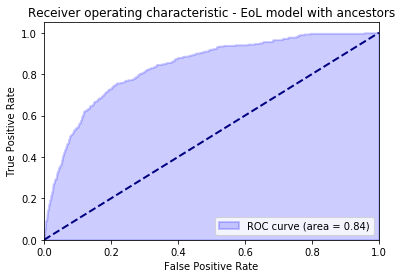

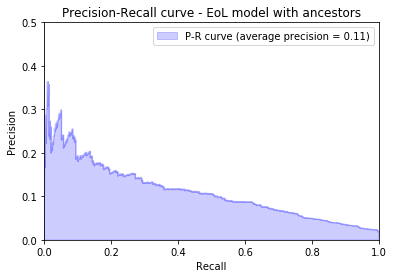

In [22]:
test_anc_pred = anc_logreg.predict_proba(test_anc_matrix)[:,1]
plot_roc_curve(test_outcomes, test_anc_pred, 'EoL model with ancestors')
plot_precision_recall_curve(test_outcomes, test_anc_pred, 'EoL model with ancestors')

In [23]:
nonanc_logreg = train_logreg_with_eval(train_nonanc_matrix, train_outcomes, valid_nonanc_matrix, valid_outcomes, \
                                       test_nonanc_matrix, test_outcomes, feature_names, \
                                       'eol_noancestors_logreg_2021Mar29_', Cs=reg_lambdas)

0.0001
Train AUC: 0.5
Valid AUC: 0.5
Test AUC: 0.5
Number of features with nonzero coefficients: 0
0.0002
Train AUC: 0.7307045583163467
Valid AUC: 0.7745029301784816
Test AUC: 0.7464652985000277
Number of features with nonzero coefficients: 4
0.0004
Train AUC: 0.7702617887511978
Valid AUC: 0.8189338235294117
Test AUC: 0.7845755060198829
Number of features with nonzero coefficients: 14
0.0008
Train AUC: 0.7982053499925179
Valid AUC: 0.837103090434892
Test AUC: 0.8039445640351593
Number of features with nonzero coefficients: 36
0.001
Train AUC: 0.8045838079670813
Valid AUC: 0.841621103569633
Test AUC: 0.8082587618616393
Number of features with nonzero coefficients: 46
0.002
Train AUC: 0.8236587431706184
Valid AUC: 0.8543689511060835
Test AUC: 0.827129426621878
Number of features with nonzero coefficients: 104
0.004
Train AUC: 0.8458674562598916
Valid AUC: 0.8661063584087483
Test AUC: 0.8389984520006843
Number of features with nonzero coefficients: 221
0.008
Train AUC: 0.8758705736316393


In [24]:
nonanc_logreg.C

0.004

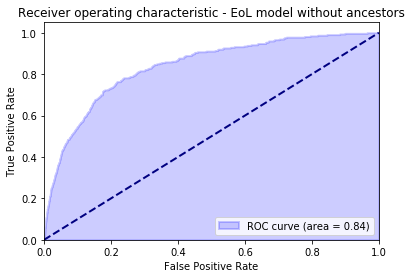

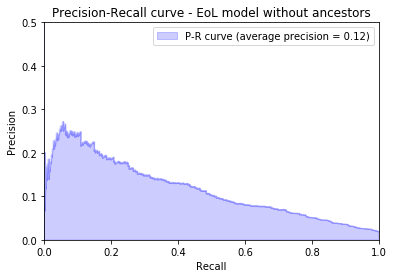

In [25]:
test_nonanc_pred = nonanc_logreg.predict_proba(test_nonanc_matrix)[:,1]
plot_roc_curve(test_outcomes, test_nonanc_pred, 'EoL model without ancestors')
plot_precision_recall_curve(test_outcomes, test_nonanc_pred, 'EoL model without ancestors')